In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter

import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
import agg_2d as agg
import viz_2d as viz
import tiling_2d as tiling
import cd
import score_funcs
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and dset

In [9]:
# load the dataset
sys.path.append('../dsets/mnist')
import dset
from model import Net
im_torch, im_orig, label = dset.get_im_and_label(250, device=device) # this will download the mnist dataset


# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# generate different frequencies

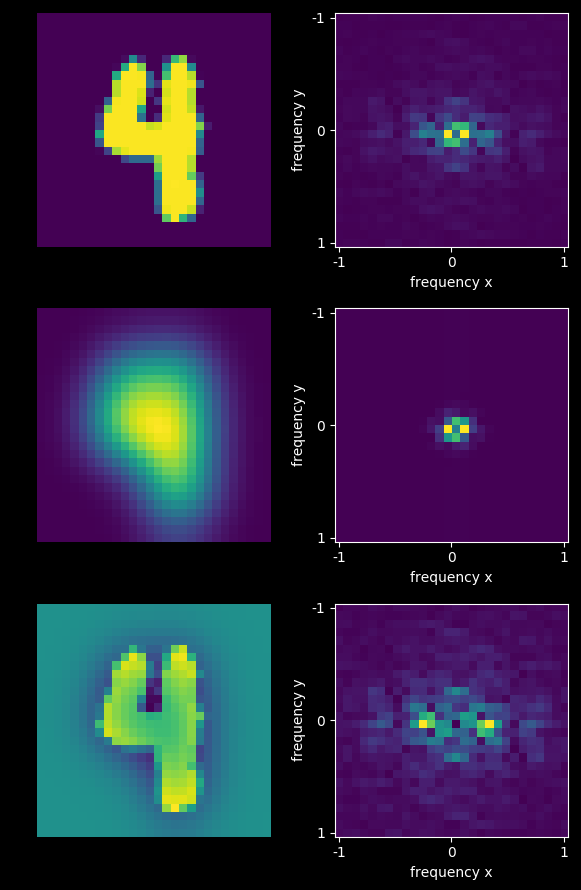

In [62]:
def visualize(im_orig, transform):
    plt.figure(dpi=100, figsize=(6, 9))
    R, C = 3, 2

    plt.subplot(R, C, 1)
    plt.imshow(im_orig)
    plt.axis('off')

    plt.subplot(R, C, 2)
    plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(im_orig))))
    plt.xticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.yticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.xlabel('frequency x')
    plt.ylabel('frequency y')


    plt.subplot(R, C, 3)
    result = transform(im_orig)
    plt.imshow(result)
    plt.axis('off')

    plt.subplot(R, C, 4)
    plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(result))))
    plt.xticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.yticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.xlabel('frequency x')
    plt.ylabel('frequency y')

    plt.subplot(R, C, 5)
    im_diff = im_orig - result
    plt.imshow(im_diff)
    plt.axis('off')

    plt.subplot(R, C, 6)
    plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(im_diff))))
    plt.xticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.yticks([0, 13.5, 27], labels=[-1, 0, 1])
    plt.xlabel('frequency x')
    plt.ylabel('frequency y')

    plt.tight_layout()
    
def transform(x): 
    if 'Tensor' in str(type(x)):
        x = x.cpu().numpy().squeeze()
        return torch.Tensor(gaussian_filter(x, sigma=3)).reshape(1, 1, 28 , 28)
    return gaussian_filter(x, sigma=3)
visualize(im_orig, transform)

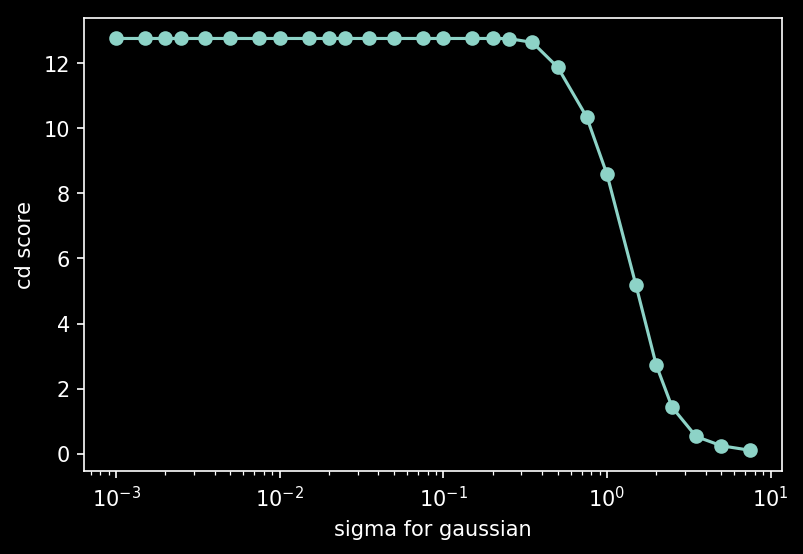

In [97]:
class_num = 4
scores = []
nums = np.array([1, 1.5, 2, 2.5, 3.5, 5, 7.5])
sigmas = list(nums * 1e-3) + list(nums * 1e-2) + list(nums * 1e-1) + list(nums * 1e0)
for sigma in sigmas:
    def transform(x): 
        if 'Tensor' in str(type(x)):
            x = x.cpu().numpy().squeeze()
            return torch.Tensor(gaussian_filter(x, sigma=sigma)).reshape(1, 1, 28 , 28)
        return gaussian_filter(x, sigma=3)
    score = cd.cd(im_torch, model, mask=None, model_type='mnist', 
          device='cuda', transform=transform)[0].flatten()[class_num].item()
    scores.append(score)
    
# plot
plt.figure(dpi=150)
plt.plot(sigmas, scores, 'o-')
plt.xlabel('sigma for gaussian')
plt.xscale('log')
plt.ylabel('cd score')
plt.show()    